### Author: Boris Kundu (kunduboris@gmail.com, 470-746-3137) ###

### Problem Statement ###
Create job recommendation engine that recommend similar jobs based on the job title and description.

### Dataset ###
https://www.kaggle.com/c/job-recommendation/data?select=jobs.zip

### Solution Outline ###
•	We can solve both these problems by using NLP techniques such as memory-based collaborative filtering (cosine similarity) to identify matching jobs.

•	When a user shows interest in a job, we can get his/her preferred job title (role) to match jobs with similar titles posted by recruiters.

•	When a user provides details such as Summary, Experience, Certifications, Skills etc. we can combine these to form a user profile and then find relevant jobs by matching his resume with job descriptions from posted jobs. 

•	For the user, the corpus will include all job details posted/present in the system. User’s preferred roles and resume will be matched against all job details.

•	The same approach can be used by recruiter to find job seekers whose preferred/current job role matches with the job title that he/she is posting. Also, their job description will be matched against all user profiles available on the system

•	For the recruiter, the corpus will include all user profiles present in the system. Recruiter’s job details will be matched against all user profiles.


### 1. Setup libraries ###
1. Install packages
2. Import packages
3. Download other libraries (as needed)

In [287]:
# Install packages - Uncomment to install

#!pip install --upgrade pip
#!pip install pandas
#!pip install numpy

#!pip install nltk

#!pip install spacy

#!pip install sklearn

import string
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

from spacy.lang.en.stop_words import STOP_WORDS

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.model_selection import GridSearchCV

### 2. Data loading ###

In [288]:
jobs = pd.read_csv('./data/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [289]:
# Check jobs
jobs.info()
jobs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091913 non-null  object
 4   Requirements  1050521 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


## 3. Exploratory Data Analysis

In [290]:
# Plot jobs by state
def plot_jobs(df,feature):
    jobs_by_state = df.groupby([feature]).size().reset_index(name= 'Count').sort_values('Count',ascending=False)
    plt.figure(figsize=(12,12))
    ax = sns.barplot(x=feature, y="Count",data=jobs_by_state)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_title(f'Jobs by {feature}')
    plt.tight_layout()
    plt.show()

In [291]:
# Check for null values
jobs.isna().sum()

JobID                0
WindowID             0
Title                7
Description         10
Requirements     41402
City                 2
State                1
Country              3
Zip5            406199
StartDate            0
EndDate              9
dtype: int64

In [292]:
# Remove jobs without title or description
jobs = jobs.dropna(subset=['Title', 'Description'])

In [293]:
# Drop unwanted fields
jobs.drop(['Zip5','WindowID', 'Requirements','StartDate','EndDate'], axis = 1, inplace=True)

In [294]:
# Lets focus on US jobs only for now
jobs = jobs.loc[jobs['Country'] == 'US']

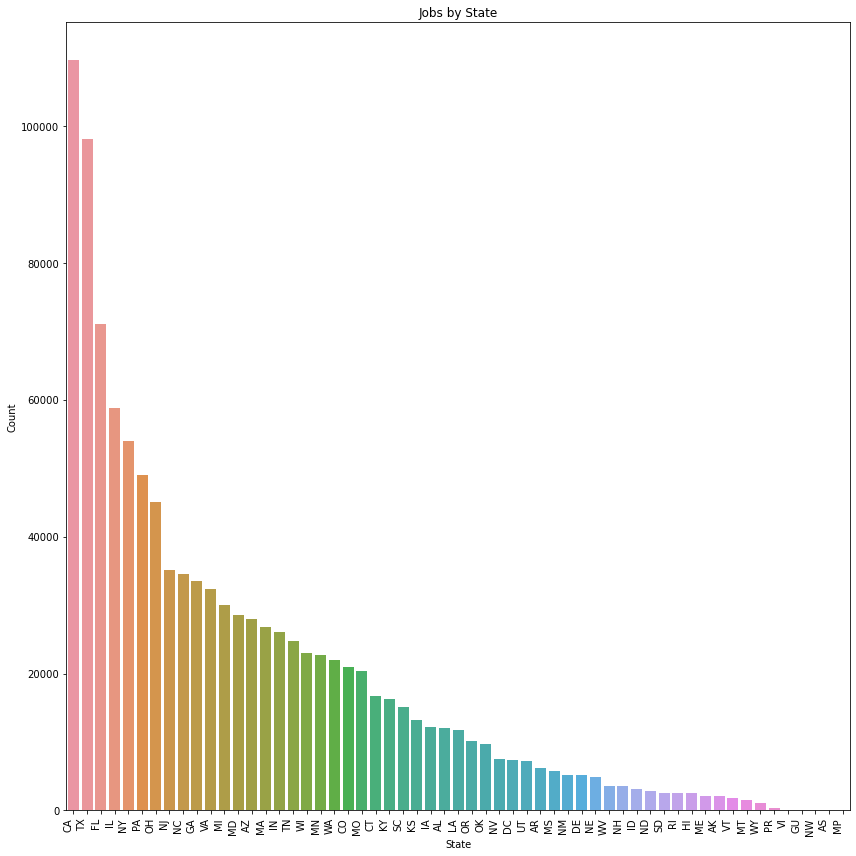

In [295]:
# Check jobs by state
plot_jobs(jobs,'State')

### 3. Data pre-processing ###

1. Clean data (punctuations, white spaces etc.)
2. Tokenize text
3. Remove stopwords
4. Lemmatize text
5. Filter unwanted Part of Speech

In [296]:
# Corpus specific stop words
custom_stop_words = [] #['opportunity', 'job', 'opening']
# POS filtering NOUN, VERB, ADJECTIVE, PROVERB
allowed_tags = ['NN','NNP','NNPS','NNS',
                'VB','VBD','VBG','VBN','VBP','VBZ',
                'JJ','JJR', 'JJS', 
                'RB', 'RBR', 'RBS']

In [297]:
# Remove punctuations
def remove_punctuation(text):
    for punc in string.punctuation:
        text = text.replace(punc, ' ')
    return text

In [298]:
# Remove noise
def clean(dataset):
    sections = [col for col in dataset.columns if dataset[col].dtype == object]
    # Replace any [],().{}
    dataset = dataset.replace(r'[\([{})\]]', ' ', regex = True)
    for sec in sections:
        # Remove numbers
        dataset[sec] = dataset[sec].str.replace(r'\d+', ' ', regex = True)
        # Lowercase text
        dataset[sec] = dataset[sec].str.lower()
        # Remove tags like <tab>
        dataset[sec] = dataset[sec].str.replace(r'<[^<>]*>', ' ', regex = True)
        # Remove standalone sequences of specials like &#
        dataset[sec] = dataset[sec].str.replace(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', regex = True)
        # Remove standalone sequences of hyphens like — or ==
        dataset[sec] = dataset[sec].str.replace('—', ' ')
        # Remove new line chaarcters '\n'
        dataset[sec] = dataset[sec].str.replace('\n',' ')
        # Remove any backslash 
        dataset[sec] = dataset[sec].str.replace(r'\\', ' ')
        # Remove any forward slash
        dataset[sec] = dataset[sec].str.replace(r'//', ' ')
        # Remove punctuations
        dataset[sec] = dataset[sec].apply(remove_punctuation)
        # Remove single characters
        dataset[sec] = dataset[sec].str.replace(r'\b\w\b', ' ', regex = True)
        # Remove sequence of white spaces
        dataset[sec] = dataset[sec].str.replace(r'\s+', ' ', regex = True)
        # Remove any leading or trailing white spaces
        dataset[sec] = dataset[sec].str.strip()
    return dataset

In [299]:
# Get all stop words
def get_stop_words(custom_stop_words):
    stop_words = STOP_WORDS.union(set(stopwords.words('english')))
    stop_words = stop_words.union(set(custom_stop_words))
    return stop_words

In [300]:
# Create doc/sentence from tokens/words/lemmas
def word2doc(words):
    text_out = ' '.join(words)
    return text_out

In [301]:
# Tokenize text
def tokenize_text(text):
    stop_words = get_stop_words(custom_stop_words)
    tokens = [token for token in nltk.tokenize.word_tokenize(text) if token not in stop_words]
    return tokens

In [302]:
# Filter words that are not NOUN, VERB, ADJECTIVE, PROVERB
def lemmatize_pos_filtering(words):
    stop_words = get_stop_words(custom_stop_words)
    wordnet_lemmatizer = WordNetLemmatizer()
    filtered_words = []
    for word in words:
        tag = nltk.pos_tag([word])[0][1]
        if tag in allowed_tags:
            tag = tag[0].lower()
            if tag == 'j':
                tag = 'a'
            else:
                tag = tag if tag in ['r', 'n', 'v'] else None
            if not tag:
                lemma = word
            else:
                lemma = wordnet_lemmatizer.lemmatize(word, tag)
            if lemma not in stop_words:
                filtered_words.append(lemma)
    return filtered_words

In [303]:
# Prepare data
def prepare_data(df, input_feature, out_feature):
    # Get tokens
    df[out_feature + '_Tokens'] = df[input_feature].apply(tokenize_text)
    # Get POS filtered words
    df[out_feature + '_Lemmas'] = df[out_feature + '_Tokens'].apply(lemmatize_pos_filtering)
    # Get POS filtered text
    df[out_feature] = df[out_feature + '_Lemmas'].apply(word2doc)
    return df

In [304]:
# Lets take 10k jobs for now
jobs_1K = jobs.iloc[0:20000]

In [305]:
# Clean job data
jobs_1K = clean(jobs_1K)

In [306]:
# Check info
jobs_1K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20003
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   JobID        20000 non-null  int64 
 1   Title        20000 non-null  object
 2   Description  20000 non-null  object
 3   City         20000 non-null  object
 4   State        20000 non-null  object
 5   Country      20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [307]:
# Prepare job description
jobs_1K = prepare_data(jobs_1K, 'Description', 'Prepared_Description')

In [308]:
# Prepare job title
jobs_1K = prepare_data(jobs_1K, 'Title', 'Prepared_Title')

In [309]:
# Check head
jobs_1K.T.head(20)

,0,1,2,3,4,5,6,7,8,9,...,19994,19995,19996,19997,19998,19999,20000,20001,20002,20003
JobID,1,4,7,8,9,10,11,12,13,14,...,78376,78391,78414,78421,78422,78423,78424,78426,78435,78436
Title,security engineer technical lead,sap business analyst wm,human resources assistant,route delivery drivers,housekeeping,salon spa coordinator,superintendent,electronic pre press professional,utility line truck operator digger derrick,construction project mgr pm trainee,...,sales representative,property manager marion county ocala florida,client account manager,advertising sales coordinator,account executive advertising travel,apartments com sales rep general assignment ou...,advertising account executive travel,inside sales representative account manager,support services,exclusive insurance sales agent outside sales ...
Description,security clearance required nbsp top secret jo...,no corp to corp resumes nbsp are being conside...,human resources assistant years experience in ...,city beverages come to work for the best in th...,make sure every part of their day is magical a...,salon spa coordinator daytona college in ormon...,superintendent central florida general contrac...,electronic pre press professional for comm she...,utility line truck operator digger derrick ope...,construction project mgr pm trainee commercial...,...,to sell advertising to geographical territory ...,this position would be responsible for marion ...,express employment professionals of roseville ...,responsible for assisting the co op advertisin...,the advertising department of the los angeles ...,apartments com division of the los angeles tim...,the advertising department of the los angeles ...,if you are seeking challenging new sales role ...,precision task group has great opportunity for...,if you truly enjoy sales and are ready to inve...
City,washington,charlotte,winter park,orlando,orlando,ormond beach,orlando,orlando,orlando,winter park,...,pompano beach,ocala,detroit,los angeles,los angeles,los angeles,los angeles,los angeles,austin,orlando
State,dc,nc,fl,fl,fl,fl,fl,fl,fl,fl,...,fl,fl,mi,ca,ca,ca,ca,ca,tx,fl
Country,us,us,us,us,us,us,us,us,us,us,...,us,us,us,us,us,us,us,us,us,us
Prepared_Description_Tokens,"[security, clearance, required, nbsp, secret, ...","[corp, corp, resumes, nbsp, considered, ldquo,...","[human, resources, assistant, years, experienc...","[city, beverages, come, work, best, business, ...","[sure, day, magical, disney, dreams, find, wal...","[salon, spa, coordinator, daytona, college, or...","[superintendent, central, florida, general, co...","[electronic, pre, press, professional, comm, s...","[utility, line, truck, operator, digger, derri...","[construction, project, mgr, pm, trainee, comm...",...,"[sell, advertising, geographical, territory, a...","[position, responsible, marion, county, fl, rp...","[express, employment, professionals, roseville...","[responsible, assisting, co, op, advertising, ...","[advertising, department, los, angeles, times,...","[apartments, com, division, los, angeles, time...","[advertising, department, los, angeles, times,...","[seeking, challenging, new, sales, role, growt...","[precision, task, group, great, opportunity, s...","[truly, enjoy, sales, ready, invest, reaping, ..."
Prepared_Description_Lemmas,"[security, clearance, require, nbsp, secret, j...","[corp, corp, resume, nbsp, consider, ldquo, di...","[human, resource, assistant, year, experience,...","[city, beverage, come, work, best, business, c...","[sure, day, magical, disney, dream, find, walt...","[salon, spa, coordinator, daytona, college, or...","[superintendent, central, florida, general, co...","[electronic, pre, press, professional, comm, s...","[utility, line, truck, operator, digger, derri...","[construction, project, mgr, pm, trainee, comm...",...,"[sell, advertising, geographical, territory, a...","[position, responsible, marion, county, fl, rp...","[express, employment, professional, roseville,...","[responsible, assist, co, op, advertis

### 5. Modeling ###

1. Hyperparameter tuning (skip)
2. Get best model with parameters (skip)
3. Define tfidf parameters based on requirement

# Define pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer())])
# Define params
params = {
            'tfidf__max_df': [0.4,0.5,0.6],
            'tfidf__min_df': [10,20,20],
            'tfidf__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)]
            }

# Perform hyperparameter tuning
def hyperparameter_tuning(pipeline, params, data, jobs = 4):
    # Init Grid Search Class
    model = GridSearchCV(estimator = pipeline, param_grid = params, n_jobs = jobs, return_train_score=True)
    # Do the Grid Search
    model.fit(data)
    # Best Model
    best_estimator = model.best_estimator_
    # Model Parameters
    print("Best Params: ", model.best_params_)
    # Score
    print("Best Score: ", model.best_score_)
    return (best_estimator)

# Get best model for description
best_desc_model = hyperparameter_tuning(pipeline, params, jobs_1K['Prepared_Description'], jobs = 4)

# Get best model for title
best_title_model = hyperparameter_tuning(pipeline, params, jobs_1K['Prepared_Title'], jobs = 4)

In [310]:
# Get vector model for description
# Only do transform after getting best model. No need to fit again.
#tf_desc = best_desc_model.named_steps['tfidf']

# Define params
tf_desc = TfidfVectorizer(max_df = 0.5, min_df = 10, ngram_range = (2,3))
# Vectorize description
tfidf_desc_data = tf_desc.fit_transform(jobs_1K['Prepared_Description'])

In [311]:
# Get vector model for description
# Only do transform after getting best model. No need to fit again.
#tf_title = best_title_model.named_steps['tfidf']

# Define params
tf_title = TfidfVectorizer(max_df = 0.8, ngram_range = (1,2))
# Vectorize description
tfidf_title_data = tf_title.fit_transform(jobs_1K['Prepared_Title'])

### 6.	Predictions ###
1. Find jobs by matching titles with user's preferred/current role
2. Find jobs by mtaching descrpition with user profile/resume content

In [312]:
# Recommend jobs
def get_top_jobs(dataset, search_title, top_matches = 5, vector_model = tf_title, vector_data = tfidf_title_data):
    # Create dataframe from search condition
    df = pd.DataFrame([search_title])
    df.columns = ['Search Query']
    # Clean text
    df = clean(df)
    # Prepare search query
    df = prepare_data(df, 'Search Query', 'Prepared Query')
    # Vectorize input
    vector_input = vector_model.transform(df['Prepared Query'])
    # Get similarity score
    sim = cosine_similarity(vector_input, vector_data)
    # Get matching jobs
    matching_jobs = dataset.iloc[np.argsort(sim[0])[::-1][0:top_matches]][["JobID", "Title", "Description"]]
    return matching_jobs

## By Title for matching preferred/current role

In [313]:
# Test 1 by Title (user's preferred/current role)
search_query = 'Software Developer'

best_matches = get_top_jobs(jobs_1K, search_query, 5, tf_title, tfidf_title_data)
best_matches.head(5)

,JobID,Title,Description
5019,18655,software developer,responsibilities this role will allow you to b...
13882,52271,software developer,description we are looking for exceptional sen...
815,2962,software developer,liberty mutual insurance “helping people live ...
16733,64454,software developer,software developer nbsp the software engineeri...
3755,15074,software developer,job summary provide programming support around...


In [314]:
# Test 2 by Title (user's preferred/current role)
search_query = 'Business Analyst'

best_matches = get_recommendations_by_title(jobs_1K, search_query, 10, tf_title, tfidf_title_data)
best_matches.head(10)

,JobID,Title,Description
13970,52539,business analyst,our partner large global financial services an...
5143,18803,business analyst,responsibilities the business analyst in beave...
13320,50183,it business analyst,position business analyst department product m...
4702,18257,business analyst,responsibilities business analyst responsibili...
19338,75377,business analyst,this is month renewable contract assignment fo...
18946,74985,business analyst,duties responsible for working with core team ...
5763,19689,business analyst,responsibilities our madison wisconsin client ...
8862,32704,business analyst,the business nbsp analyst will lead the develo...
99,264,business analyst,we don just see the value of our performance w...
16329,61955,business analyst,we are looking for motivated enthusiastic and ...


## By Description for matching resume/profile content

In [315]:
# Test 3 by Description (user's resume/profile content)
search_query = "Developed, maintained, and documented solutions for different client's user interface and inventory management systems by leveraging industry best practices, development tools, programming, and web engineering languages (Java, PL-SQL, SQL, Shell, Unix, ANT, Gradle, JSP, HTML, JS, MVC, SOAP, REST, SONAR, JUnit, Oracle, SVN). Modeled network inventory data and metadata, performed product upgrades, merged and migrated data for different clients."

best_matches = get_top_jobs(jobs_1K, search_query, 5, tf_desc, tfidf_desc_data)
best_matches.head(5)

,JobID,Title,Description
6305,23798,oracle ebs techno functional consultant,oracle ebs techno functional consultant ebusin...
3148,12760,software engineer,security clearance secret • demonstrated stron...
3176,12789,java web developer with ajax json development ...,security clearance public trust experience dev...
1329,5419,software engineer,software engineer job immediate need with worl...
18971,75010,web production support analyst houston tx,we have month contract job opening in houston ...
